ㅑ# [SWCON253] Machine Learning
Instructor: Eunseop Shin (kairos9603@khu.ac.kr)

Professor: Hui Yong Kim (hykim.v@khu.ac.kr)

---

# P3.A: 직접 구현해보는 K-Means 군집화 (5점)

### 학습목표
- K-Means 모델을 직접 구현하면서 EM알고리즘에 대해 이해할 수 있다.

### 실습내용
K-Means 모델을 직접 구현합니다.

실습은 다음 순서로 진행됩니다.
- 1) 데이터셋 loading
- 2) 모델 구현, 학습 **<직접 구현>**
- 3) Discussion

**이번 실습에서 여러분은 `2)` 부분의 코드를 직접 작성합니다.**

### 점수
- 모델 구현 학습: 5점

`.ipynb 파일과 함께 .html 파일 (File -> export as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.`

## Imports

In [46]:
from sklearn import datasets
import pandas as pd
import numpy as np
import math
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1) Loading the Dataset
Blobs dataset을 생성합니다.

Scikit-learn에서는 클러스터링 모델 학습을 위한 클러스터 데이터를 생성할 수 있습니다.
`datasets.make_blobs`함수를 이용하여 총 4개의 클러스터를 갖는 데이터셋을 만들어보겠습니다.

In [47]:
X, Y = datasets.make_blobs(n_samples=100, centers=3, cluster_std=1.2, n_features=2, random_state=10)  # make dataset

points = pd.DataFrame(X, Y).reset_index(drop=True)
points.columns = ["x", "y"]
points.head()

,x,y
0,-2.783984,-6.939182
1,0.628254,-4.780228
2,2.397029,3.620616
3,5.906665,-9.990120
4,1.905010,5.352674


### Dataset Visualization
데이터셋이 어떤 분포로 생겼는지 시각화하여 살펴봅니다.
데이터셋을 생성할 때 `centers`를 3으로 했기 때문에 3개의 군집이 생긴것을 확인 할 수 있습니다.

<AxesSubplot:xlabel='x', ylabel='y'>

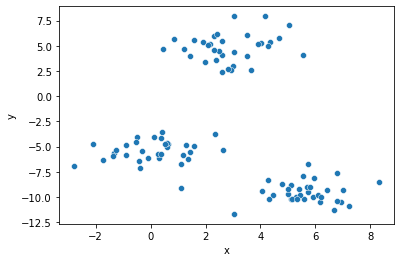

In [48]:
# 데이터셋 plot
sns.scatterplot(x="x", y="y", data=points, palette="Set2")

## 2)모델 구현, 학습
K-Means모델을 직접 학습해보고 EM알고리즘에 대해 이해해봅니다.

K-Means 모델은 클러스터링중 가장 널리 사용되고 있는 모델입니다. K개의 클러스터를 설정하면 EM알고리즘에의해 클러스터의 중심값을 평균값으로 업데이트 해 나아가면서 최적의 해를 찾게됩니다.

Kmeans 학습은 다음과정을 통해 학습됩니다.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/K_Means_Example_Step_1.svg/124px-K_Means_Example_Step_1.svg.png)

1) 클러스러 평균값을 랜덤으로 초기화하여 지정합니다.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/K_Means_Example_Step_2.svg/139px-K_Means_Example_Step_2.svg.png)

2) 각 데이터 샘플들은 가장 가까이 있는 평균값을 기준으로 묶습니다. 평균값을 기준으로 분할된 영역은 보로노이 다이어그램으로 표시할수 있습니다. 이 과정이 EM알고리즘에서 Estimation 과정입니다.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3e/K_Means_Example_Step_3.svg/139px-K_Means_Example_Step_3.svg.png)

3) K개의 클러스터의 중심값을 기준으로 평균값을 업데이트합니다. 이 과정이 Maximization 과정입니다.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/K_Means_Example_Step_4.svg/139px-K_Means_Example_Step_4.svg.png)

4) 수렴할때까지 2), 3) 과정을 반복합니다.

이제부터 K-Means 알고리즘을 직접 구현해봅니다.

### Step 1.
K-Means알고리즘은 미리 클러스터 갯수인 K값을 지정해야합니다. 적당한 K 값을 지정하세요.
지정한 값에 맞춰서 초기 중심점을 샘플에서 랜덤으로 선택합니다.

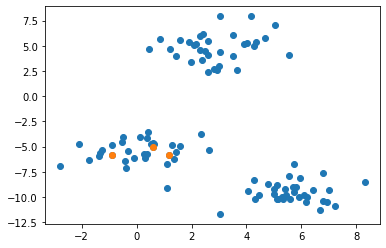

In [49]:
def initialization_kmeans(K, random_state=15):
    # select random initial centroid
    centroids = points.sample(K, random_state=random_state)
    return centroids


K = 3   # <your code> define number of clusters
centroids = initialization_kmeans(K)

# visualization
plt.scatter(points['x'], points['y'])
plt.scatter(centroids['x'], centroids['y'])
plt.show()

### Step 2.
모든 샘플에서 각 중심점으로부터의 거리를 구하고 가장 가까운거리의 클러스터로 해당 샘플을 할당합니다.

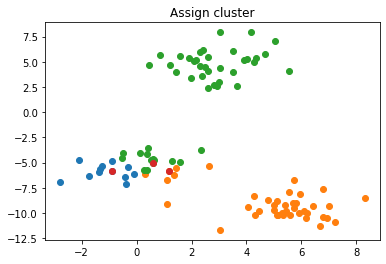

In [50]:
def assign_cluster(points, centroids):
    # caclulate distance with points and centroids.
    distance = sp.spatial.distance.cdist(points[["x", "y"]], centroids, "euclidean")

    # assigned to the cluster of the center point with the shortest distance
    cluster_num = np.argmin(distance,axis=1)

    result = points.copy()
    result["cluster"] = np.array(cluster_num)
    return result


def show_clusters(points, centroids, K, title=""):
    for i in range(K):
        sampels = points.loc[points.cluster == i]
        plt.scatter(sampels['x'], sampels['y'])
    plt.scatter(centroids['x'], centroids['y'])
    plt.title(title)
    plt.show()


result = assign_cluster(points, centroids)
show_clusters(result, centroids, K, title="Assign cluster")

### Step 3.
클러스터의 평균값으로 중심점을 업데이트합니다.

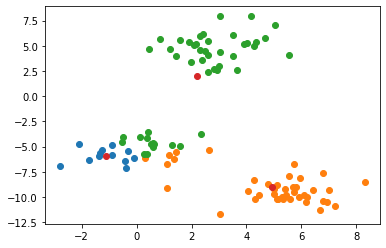

In [51]:
def update_centroids(result):
    centroids = result.groupby("cluster").mean()
    return centroids

centroids = update_centroids(result=result)
show_clusters(result, centroids, K)

### Step 4. 
수렴 할 때 까지 step 2. step 3.을 반복합니다.

> 위에서 정의한 코드를 사용하여 아래 `<your code>` 부분을 완성하세요.

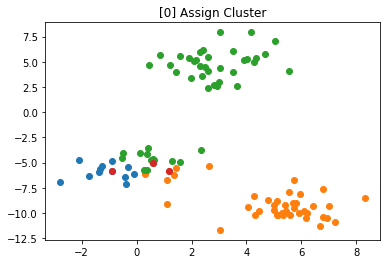

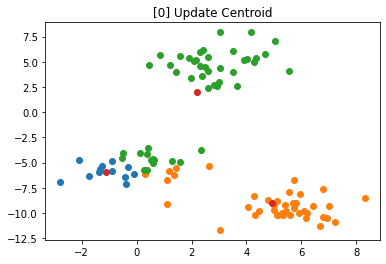

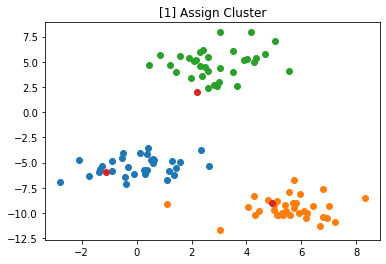

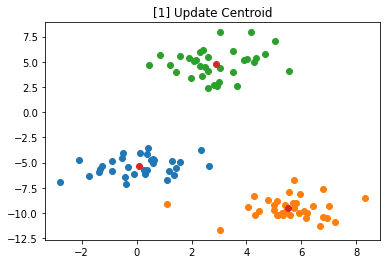

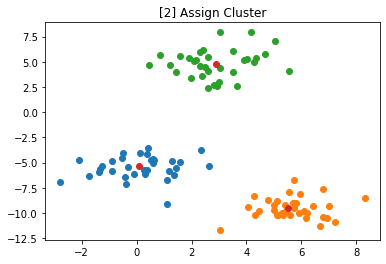

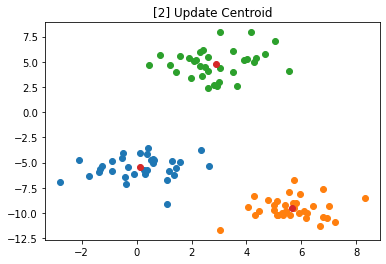

In [57]:
def kmeans(points, K, max_iter=3, random_state=15):
    # step 1.
    centroids =  initialization_kmeans(K, random_state=random_state)

    for i in range(max_iter):
        # step 2.
        result = assign_cluster(points, centroids)# <your code> assigne sample to cluster. Use defined function.
        show_clusters(result, centroids, K, title=f"[{i}] Assign Cluster")

        # step 3.
        centroids = update_centroids(result=result)# <your code> update centroids. Use defined function.
        show_clusters(result, centroids, K, title=f"[{i}] Update Centroid")

    return points, centroids

K = 3 # <your code> set number of Clusters
random_state = 15
points, centroids = kmeans(points, K, random_state=random_state)


## 3) Discussion

**1) random state를 다르게 변화하여 돌려보고 나타나는 문제에 대해서 설명해보세요.**
random_state를 15로 설정했을 때는 각각의 cluster가 예상했던 대로 구분되었지만,
random_state를 20으로 설정했을 때는 예상과 다르게, 눈으로 보여지는 것과 다르게 clustering이 된 결과를 확인할 수 있었다.

**2) 문제 1번에서 나타난 문제를 해결할 수 있는 방안은 무엇이 있나요?**
여러 번 initial point를 설정하여 나온 결과 중 하나를 최종적인 결과로 선택하거나, 예상 cluster 수 보다 많은 initial point를 처음에 설정한 뒤,
이후에 cluster를 선택하거나 제거할 수 있을 것 같다.

**3) 구현하면서 든 질문에 대해 적고, 답할 수 있다면 스스로 답해보세요.**
random_state를 직접 설정하게 해 준 이유가 궁금했는데, debugging 시 이전과 같은 상황을 똑같이 구현하기 위해서 이렇게 만들었다는 것을 알게 되었다.

---

# P3.B:  scikit-learn을 이용한 클러스터링 (5점)

### 학습목표
- KMeans 모델을 이용하여 Iris 데이터를 군집화 할 수 있다.
- Scikit-Learn을 이용하여 모델 학습, 검증 과정을 구현할 수 있다.

### 실습내용
Scikit-Learn의 KMeans를 이용하여 군집화를 학습해 봅니다. 

실습은 다음 순서로 진행됩니다.
- 1) 데이터셋 loading
- 2) KMeans 모델 구현, 학습, 검증, Decision Boundary 시각화 **<직접 구현>**
- 3) Discussion

**이번 실습에서 여러분은 `2) KMeans 모델 구현, 학습, 검증, Decision Boundary 시각화` 부분의 코드를 직접 작성합니다.**

앞으로 대부분의 실습도 위와 같은 순서로 진행됩니다. 이번 실습을 통해 각 부분의 코드를 이해하고 다음 실습에 참고하도록합니다.


### 점수
- `<your code>` 부분 각 1점 (총 3점)
- Discussion 부분 2점

`.ipynb 파일과 함께 .html 파일 (File -> export as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.`

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1) 데이터셋 loading
P3 실습에서 사용하였던 IRIS 데이터를 사용합니다.

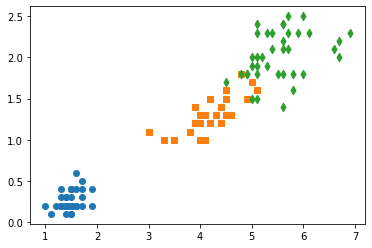

In [68]:
iris = datasets.load_iris()
X = iris.data[:, 2:4]  # we only take the first two features.
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y) # <your code> split dataset into trainset and testset with `train_test_split` function

# 데이터셋 plot
plt.scatter([i[0] for idx, i in enumerate(X_train) if y_train[idx] == 0], 
            [i[1] for idx, i in enumerate(X_train) if y_train[idx] == 0],
            marker='o')

plt.scatter([i[0] for idx, i in enumerate(X_train) if y_train[idx] == 1], 
            [i[1] for idx, i in enumerate(X_train) if y_train[idx] == 1],
            marker='s')

plt.scatter([i[0] for idx, i in enumerate(X_train) if y_train[idx] == 2], 
            [i[1] for idx, i in enumerate(X_train) if y_train[idx] == 2],
            marker='d')
plt.show()

## 2) K-Means 모델 구현, 학습

K-Means모델을 이용하여 위 데이터셋을 군집화해 봅니다.

In [71]:
# 기존의 선형 커널로 분류를 시도해 봅니다.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

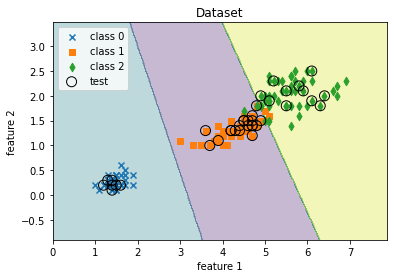

In [72]:
### 데이터셋에서 Decision Boundary 시각화
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                       np.arange(x2_min, x2_max, 0.02))
Z = kmeans.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, alpha=0.3)

# 그래프로 표현
plt.scatter([i[0] for idx, i in enumerate(X) if y[idx] == 0], 
            [i[1] for idx, i in enumerate(X) if y[idx] == 0],
            label='class 0', marker='x')
plt.scatter([i[0] for idx, i in enumerate(X) if y[idx] == 1], 
            [i[1] for idx, i in enumerate(X) if y[idx] == 1],
            label='class 1', marker='s')
plt.scatter([i[0] for idx, i in enumerate(X) if y[idx] == 2], 
            [i[1] for idx, i in enumerate(X) if y[idx] == 2],
            label='class 2', marker='d')
## testset 강조
plt.scatter([i[0] for idx, i in enumerate(X_test)],
            [i[1] for idx, i in enumerate(X_test)],
            label='test', facecolors='none', edgecolor='black', s=100, marker='o')

# 그래프로 표현
plt.title('Dataset')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

## 3) Discussion

**1) KMeans로 풀리지 않는 문제는 어떤것이 있나요?**

cluster 의 모양이 원형이 아닌 경우 문제 해결이 어려울 수 있을 것 같다.

**2) KMeans로 풀리지 않는 문제의 경우 어떤 알고리즘을 사용하면 되나요?**

새로운 특징 공간으로 변환하여 KMeans를 사용하면 풀 수 있는 문제가 많아질 것이라고 생각한다.

또한, Density-Based Spatial Clustering of Applications with Noise (DBSCAN) 이라는 알고리즘을 사용하면 cluster의 모양이 꼭 원형이 아닌 경우에, cluster를 찾아주기 유용할 것 같습니다. (아래 그림)

![](https://t1.daumcdn.net/cfile/tistory/9946C4485BD19C1C1C)

**3) 구현하면서 든 질문에 대해 적고 스스로 답해보세요.**

위의 2) 문제에 대한 보다 정확한 답이 궁금합니다. 앞서 말씀드린 DBSCAN을 사용해도, 제시된 데이터셋에 대해서는 적절한 clustering이 이루어지지 않을 것이라고 생각하기 때문입니다.